# `rainfall_matches_going_conditions.ipynb`

### Author: Anthony Hein

#### Last updated: 11/22/2021

# Overview:

This notebook shows that the going is related to the measured rainfall.

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
from typing import List
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `races_featurized.csv`

In [3]:
races_featurized = pd.read_csv(f"{BASE_DIR}/data/streamline/races_featurized.csv", low_memory=False) 
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,1,0,0,0,0,0,0,1,1.350363
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,1,0,0,1,0,0,0,0,1,1.995151
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,1,0,0,0,0,0,0,1,0,1.786421
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,1,0,0,0,0,0,1,0,1.611062
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,1,0,0,0,0,0,1,0,0,1.254374


In [4]:
races_featurized.shape

(20201, 129)

In [5]:
list(races_featurized.columns)

['rid',
 'course',
 'title',
 'winningTime',
 'metric',
 'ncond',
 'class',
 'runners',
 'margin',
 '1st_place_rank_in_odds',
 '2nd_place_rank_in_odds',
 '3rd_place_rank_in_odds',
 '1st_rank_in_odds_place',
 '2nd_rank_in_odds_place',
 '3rd_rank_in_odds_place',
 'placeAvailable',
 'showAvailable',
 'favoriteWon',
 'favoritePlaced',
 'favoriteShowed',
 'lat',
 'lng',
 'datetime',
 'station no',
 'station name',
 'station lat',
 'station lng',
 'dist to station',
 'station reading date',
 'temp',
 'msl',
 'rain',
 'rhum',
 'station reading timedelta',
 'course__Ballinrobe',
 'course__Bellewstown',
 'course__Clonmel',
 'course__Cork',
 'course__Curragh',
 'course__Down Royal',
 'course__Downpatrick',
 'course__Dundalk',
 'course__Fairyhouse',
 'course__Galway',
 'course__Gowran Park',
 'course__Killarney',
 'course__Leopardstown',
 'course__Limerick',
 'course__Listowel',
 'course__Naas',
 'course__Navan',
 'course__Other',
 'course__Punchestown',
 'course__Roscommon',
 'course__Sligo',
 '

---

## Load `horses_selected_trimmed_clean.csv`

In [6]:
horses_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/horses_selected_trimmed_clean.csv", low_memory=False) 
horses_clean.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,RPR,TR,OR,father,mother,gfather,weight,res_win,res_place,res_show
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,0,...,102.0,NaN,NaN,King's Ride,Browne's Return,Deep Run,73,1,1,0
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,94.0,NaN,NaN,Long Pond,Courtlough Lady,Giolla Mear,73,0,1,0
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,92.0,NaN,NaN,Nordico,Over The Seas,North Summit,71,0,0,0
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,NaN,NaN,Roselier,Miss Reindeer,Reindeer,73,0,0,0
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,NaN,NaN,Noalto,Elena's Beauty,Tarqogan,66,0,0,0


In [7]:
horses_clean.shape

(202304, 22)

---

## Load `races_selected.csv`

We need this to make a mapping from the condition code to the interpretation of this code.

In [8]:
races_selected = pd.read_csv(f"{BASE_DIR}/data/streamline/races_selected.csv", low_memory=False) 
races_selected.head()

,rid,course,time,date,title,rclass,band,ages,distance,condition,hurdles,prizes,winningTime,prize,metric,countryCode,ncond,class,runners
0,302858,Thurles (IRE),01:15,97/01/09,Liffey Maiden Hurdle (Div 1),NaN,NaN,5yo+,2m3f,Good,NaN,[],277.2,NaN,3821.0,IE,1,0,6
1,291347,Punchestown (IRE),03:40,97/02/16,Ericsson G.S.M. Grand National Trial Handicap ...,NaN,NaN,5yo+,3m2f,Soft,NaN,[],447.2,NaN,5229.0,IE,5,0,9
2,75447,Listowel (IRE),03:00,97/03/01,Ballybunion E.B.F. Beginners S'chase,NaN,NaN,4yo+,2m2f,Soft,NaN,[],318.4,NaN,3620.0,IE,5,0,8
3,358038,Punchestown (IRE),02:40,97/04/24,Quinns Of Baltinglass Chase (La Touche) (Cross...,NaN,NaN,5yo+,4m1f,Good,NaN,[],533.9,NaN,6637.0,IE,1,0,10
4,78982,Dundalk (IRE),05:15,97/05/02,Carlingford Handicap Chase,NaN,0-109,4yo+,3m,Firm,NaN,[],370.3,NaN,4827.0,IE,8,0,4


In [9]:
ncond_to_condition = races_selected[['condition', 'ncond']].value_counts().to_dict()
ncond_to_condition = {k[1]: k[0] for k, _ in ncond_to_condition.items()}
ncond_to_condition

{1: 'Good',
 0: 'Standard',
 2: 'Good To Firm',
 5: 'Soft',
 9: 'Heavy',
 6: 'Yielding',
 4: 'Good To Yielding',
 11: 'Yielding To Soft',
 12: 'Soft To Heavy',
 8: 'Firm',
 10: 'Good To Soft',
 17: 'Slow'}

These are confusing. Let's simplify these.

In [10]:
ncond_to_simpler = {
    0: 'Good',
    1: 'Good',
    2: 'Firm',
    4: 'Soft',
    5: 'Soft',
    6: 'Soft',
    8: 'Firm',
    9: 'Heavy',
    10: 'Soft',
    11: 'Soft',
    12: 'Heavy',
    17: 'Heavy'
}

In [11]:
races_featurized['simpler_ncond'] = races_featurized['ncond'].map(lambda x: ncond_to_simpler[x])

---

## Rainfall Matches Going Conditions

In [12]:
dfa = races_featurized[
    (races_featurized['is_raining'] == 0)
]

dfb = races_featurized[
    ~((races_featurized['is_raining'] == 0))
]

len(dfa), len(dfb)

(16990, 3211)

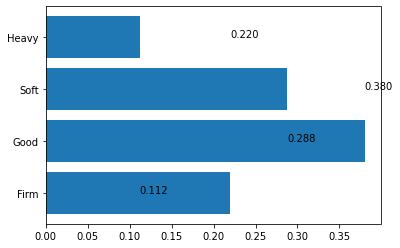

{'Firm': 0.22007062978222483,
 'Good': 0.3799293702177752,
 'Soft': 0.28799293702177753,
 'Heavy': 0.11200706297822248}

In [44]:
d_dfa = dfa['simpler_ncond'].value_counts(normalize=True).to_dict()
d_dfa = {
    'Firm': d_dfa['Firm'],
    'Good': d_dfa['Good'],
    'Soft': d_dfa['Soft'],
    'Heavy': d_dfa['Heavy'],
}

plt.barh(list(d_dfa.keys()), list(d_dfa.values()))

for index, value in enumerate(d.values()):
    plt.text(value, index, "%.3f" % value)
    
plt.show()
d_dfa

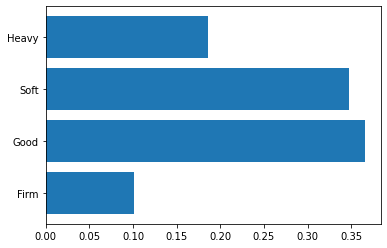

{'Firm': 0.10152600436001245,
 'Good': 0.3653067580193086,
 'Soft': 0.3475552787293678,
 'Heavy': 0.18561195889131113}

In [43]:
d_dfb = dfb['simpler_ncond'].value_counts(normalize=True).to_dict()
d_dfb = {
    'Firm': d_dfb['Firm'],
    'Good': d_dfb['Good'],
    'Soft': d_dfb['Soft'],
    'Heavy': d_dfb['Heavy'],
}

plt.barh(list(d_dfb.keys()), list(d_dfb.values()))

# for index, value in enumerate(d.values()):
#     plt.text(value, index, "%.3f" % value)
    
plt.show()
d_dfb

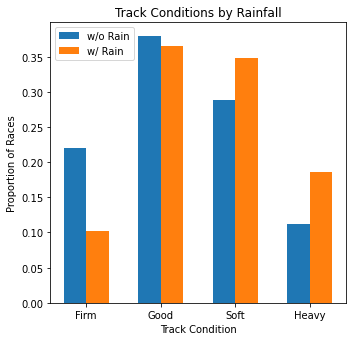

In [42]:
fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(1, 1)

fig.suptitle("")

ax1 = fig.add_subplot(gs[0:1, 0:1])

ax1.set_title("Track Conditions by Rainfall")

ind = np.arange(len(d_dfa.keys()))
width = 0.3

ax1.bar(
    ind,
    list(d_dfa.values()),
    width,
    label="w/o Rain"
)

ax1.bar(
    ind + width,
    list(d_dfb.values()),
    width,
    label="w/ Rain"
)

plt.xticks(ind + width / 2, ('Firm', 'Good', 'Soft', 'Heavy'))

ax1.set_xlabel("Track Condition")
ax1.set_ylabel("Proportion of Races")
ax1.legend(loc='upper left')

plt.tight_layout()

fig.savefig(f"{BASE_DIR}/figures/track_conditions_by_rainfall.png")

plt.show()

---